# Supervised learning

In this notebook we focus on **supervised learning**, which is a set of algorithms that take **labeled** data and try to **predict** the label using the other **features** in the data. Supervised learning by far comprises the most application of machine learning, although **reinforcement learning** is catching up too. Unlike **un-supervised learning** where the data is not labeled and hence there's a lot of subjectivity, **supervised learning** algorithms, once trained on data, can easily be evaluated by just comparing their **predictions** to the **labels** (in this context, we refer to the labels sometimes as **ground truth**).

As usual, let's begin by reading some data. We use a bank marketing data, which has demographic and activity data about bank customers, as well as information about previous attempts to contact them for a marketing campain. The target `y` is binary and indicates whether the client signed up for a term deposit or not.

You can read more about the data [here](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing).

In [1]:
import pandas as pd

bank = pd.read_csv("data/bank-full.csv", sep = ";")
bank.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Since numeric and categorical features are often pre-processed differently, we will create variables that store the names of each to make it easier to refer to them later.

In [2]:
num_cols = bank.select_dtypes(['integer', 'float']).columns
cat_cols = bank.select_dtypes(['object']).drop(columns = "y").columns

print(f"Numeric columns are {num_cols}.")
print(f"Categorical columns are {cat_cols}.")

Numeric columns are Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object').
Categorical columns are Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
       'month', 'poutcome'],
      dtype='object').


As usual before we can proceed to machine learning, we need to get the data ready. And since we're doing supervised learning, we need to set aside a test data set to later be evaluate the model. So let's begin by splitting the data.

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(bank.drop(columns = "y"), bank["y"], 
                                                    test_size = 0.15, random_state = 42)

In [4]:
X_train = X_train.reset_index(drop = True)
X_test = X_test.reset_index(drop = True)

In [5]:
print(f"Training data has {X_train.shape[0]} rows.")
print(f"Test data has {X_test.shape[0]} rows.")

Training data has 38429 rows.
Test data has 6782 rows.


Before we begin our journey of trying out different algorithms in `sklearn` we do need to encode our categorical features.

In [6]:
from sklearn.preprocessing import OneHotEncoder

onehoter = OneHotEncoder(sparse = False, drop = "first")
onehoter.fit(X_train[cat_cols])
onehot_cols = onehoter.get_feature_names(cat_cols)
X_train_onehot = pd.DataFrame(onehoter.transform(X_train[cat_cols]), columns = onehot_cols)
X_test_onehot = pd.DataFrame(onehoter.transform(X_test[cat_cols]), columns = onehot_cols)

Some algorithms we're going to use (such as decision tree) won't require that we normalize our numeric features, but most will. Not doing so won't break the algorithm, but just as we saw in the case of k-means, it will skew the results. So let's Z-normalize our numeric features now.

In [7]:
from sklearn.preprocessing import StandardScaler

znormalizer = StandardScaler()
znormalizer.fit(X_train[num_cols])
X_train_norm = pd.DataFrame(znormalizer.transform(X_train[num_cols]), columns = num_cols)
X_test_norm = pd.DataFrame(znormalizer.transform(X_test[num_cols]), columns = num_cols)
X_train_norm.head()

,age,balance,day,duration,campaign,pdays,previous
0,1.135454,-0.441514,1.342893,1.905285,-0.565758,-0.410605,-0.246723
1,0.193989,-0.393007,1.463034,0.127461,1.355238,-0.410605,-0.246723
2,-1.312355,-0.500045,1.583175,-0.685592,0.394740,-0.410605,-0.246723
3,-0.088451,-0.382982,-0.459220,-0.654471,1.035072,-0.410605,-0.246723
4,0.005696,-0.441514,-0.819643,-0.747835,0.074574,-0.410605,-0.246723


We now join our numeric features and our one-hot-encoded categorical features into one data set that we pass to the decision tree classifier.

In [8]:
X_train_featurized = X_train_onehot # add one-hot-encoded columns
X_test_featurized = X_test_onehot   # add one-hot-encoded columns
X_train_featurized[num_cols] = X_train_norm # add numeric columns
X_test_featurized[num_cols] = X_test_norm   # add numeric columns

del X_train_norm, X_test_norm, X_train_onehot, X_test_onehot

print("Featurized training data has {} rows and {} columns.".format(*X_train_featurized.shape))
print("Featurized test data has {} rows and {} columns.".format(*X_test_featurized.shape))

Featurized training data has 38429 rows and 42 columns.
Featurized test data has 6782 rows and 42 columns.


## Decision tree classifier

With our data ready, we can now train a decision tree classifier. There is a lot of detail that we leave for another time, but the common pattern to all the supervised learning algorithm is what we want to call attention to here: 

1. We create an **instance** of the algorithm, along with any settings we want to use. Here we instantiate a `DecisionTreeClassifier` and specify `max_depth = 10`.
1. We train the algorithm on the training data by calling the `fit` method.
1. Once the model is trained, we obtain prediction by calling the `predict` method.

In [9]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(max_depth = 15)
dtree.fit(X_train_featurized, y_train)

y_hat_train = dtree.predict(X_train_featurized)
y_hat_test = dtree.predict(X_test_featurized)

If we wish to evaluate the model, we only need to predict for the test data, but in our case we predict both for the training and test data so we can show the effect of overfitting or underfitting.

In [10]:
from sklearn.metrics import accuracy_score

acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print(f"Accuracy on the training data: {acc_train:.0f}%.")
print(f"Accuracy on the test data: {acc_test:.0f}%.")

Accuracy on the training data: 96%.
Accuracy on the test data: 90%.


### Exercise

We will talk in a future lecture about what all different ways to evaluate classification models, but in the above snippet we are using **accuracy**, which is the percentage of predictions that match the true labels. In other words, the percentage of rows $i$ where $Y_i = \hat Y_i$. 

- Return to the `DecisionTreeClassifier` above and try some larger and smaller value for `max_depth`. What do you notice about the accuracy of the training and test data as you change `max_depth`? We can use `max_depth` to "fiddle" with the model we get: `max_depth` is an example of what we call a **hyper-parameter** and the task of fiddling with a model's hyper-parameter is called **hyper-parameter tuning**.
- Every algorithm has hyper-parameters. Most are unique to the algorithm: for example `max_depth` is unique to tree-based algorithms like decision trees and random forests. Return to the classifier above and look up what are some other hyper-parameters are?

### End of exercise

So we know how accurate our model is, but what if we want to know which features contributed the most to the model? We passed a lot of features to the model, but most likely, a lot of those features were not really that useful to the prediction. Foretunately, decision trees also return **feature importance** values. Note that numeric features correspond to the numeric columns in the data. However, since we one-hot-encoded the categorical features, every category of every categorical column in the original data gets its own feature.

Here's how we can plot the top 10 most important features to the model, starting with the most important features at the top.

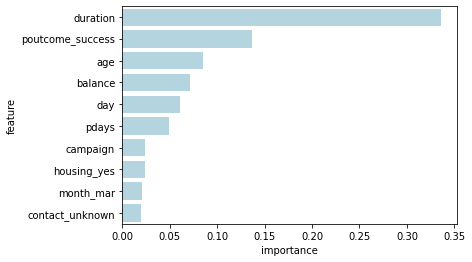

In [11]:
df_var_imp = pd.DataFrame({"feature": X_train_featurized.columns, 
                           "importance": dtree.feature_importances_})
df_var_imp.sort_values(by = "importance", ascending = False, inplace = True)

import seaborn as sns
ax = sns.barplot(x = "importance", 
                 y = "feature", 
                 data = df_var_imp.head(10), 
                 color = "lightblue")

Even though we didn't plot it, when we use decision trees to train model a model, the trained model is (you guessed it!) a tree! This means that to get a prediction for any new data, we start at the top of the tree (called the **root**) and based on the data values we ultimately finish in one of the **leaves** of the tree, at which point we predict whatever the prediction is at the leaf we landed in.

## k-nearest neighbor classifier

A model trained using the k-nearest neighbor algorithm on the other hand is very different. It doesn't have a tree structure. Instead it labels a new data point by finding the $k$ points nearest to it and looking up what their labels are, and letting the new data's label be the same as whatever label the majority of its neighbors have. Optionally, we can let closer neighbors influence the vote more than more distant neighbors.

In [12]:
from sklearn.neighbors import KNeighborsClassifier

knnb = KNeighborsClassifier(n_neighbors=10)
knnb.fit(X_train_featurized, y_train)

y_hat_train = knnb.predict(X_train_featurized)
y_hat_test = knnb.predict(X_test_featurized)

If we wish to evaluate the model, we only need to predict for the test data, but in our case we predict both for the training and test data so we can show the effect of overfitting or underfitting.

In [13]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print(f"Accuracy on the training data: {acc_train:.0f}%.")
print(f"Accuracy on the test data: {acc_test:.0f}%.")

Accuracy on the training data: 91%.
Accuracy on the test data: 90%.


### Exercise

- The `KNeighborsClassifier` classifier has a hyper-parameter called `n_neighbors`. Try a few different values and report how it affects the accuracy on training and test data. Are you more likely to overfit if you choose a smaller value or a larger one?
- The `KNeighborsClassifier` classifier has another hyper-parameter called `weights`. Read up on what this hyper-parameter does and change its value to something other than the default value. How does this affect your results?
- Instead of calling the `predict` method to get predictions, in the cell below call the `predict_proba` method and examine the results. How do the results returned by the `predict` and `predict_proba` methods relate to each other? HINT: You can try to examine the results by just looking at them, but `numpy` arrays have a method called `argmax` that can come in very handy here.

In [38]:
y_hat_prob_train = knnb.predict_proba(X_train_featurized)
y_hat_prob_test = knnb.predict_proba(X_test_featurized)

#acc_train = accuracy_score(y_train, y_hat_prob_train) * 100
#acc_test = accuracy_score(y_test, y_hat_prob_test) * 100

In [50]:
# shape
print(y_hat_prob_test.shape)
print(y_hat_test.shape)

# that's interesting..... multiple dimensions in the predict_proba result
print(y_hat_prob_test[1])
print(y_hat_test[1])

# ahhh.... the 

(6782, 2)
(6782,)
[1. 0.]
no


Decision trees also have a method called `predict_proba`. Calling `predict` returns what we call **hard predictions** and calling `predict_proba` returns **soft predictions**.

### End of exercise

## Logistic regression classifier

The logistic regression algorithm is another popular classifier. Careful here: even though it has the word **regression** in it, logistic regression is a **classification** algorithm, not a **regression** algorithm. A model trained using logistic regression predicts new classes using an **equation**. This makes logistic regression very efficient. In fact, once you have your trained model, you can pull out the equation's **coefficients** and implement it even in SQL: in just one query, although if we have a lot of features it could be nasty query!

In [ ]:
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(max_iter = 5000)
logit.fit(X_train_featurized, y_train)

y_hat_train = logit.predict(X_train_featurized)
y_hat_test = logit.predict(X_test_featurized)

If we wish to evaluate the model, we only need to predict for the test data, but in our case we predict both for the training and test data so we can show the effect of overfitting or underfitting.

In [ ]:
acc_train = accuracy_score(y_train, y_hat_train) * 100
acc_test = accuracy_score(y_test, y_hat_test) * 100

print("Accuracy on the training data: {:.0f}%.".format(acc_train))
print("Accuracy on the test data: {:.0f}%.".format(acc_test))

So what does trained model's equation look like. To get the acutal equation we need to do some string processing with Python. Of course to get the predictions, we don't need to manually create the equation: we just need to call the `predict` method. But if we insisted on seeing the equation, we can run the next cell. 

NOTE: this equation gives us what is called the **log-odds ratio**, and with a simple transformation that we skipped here, we can get the probability $P(Y_i = 1)$ from the log-odds ratio.

In [ ]:
variables = list(X_train_featurized.columns)
coefficients = map(str, list(logit.coef_[0]))
intercept = logit.intercept_[0]

var_coef_pairs = list(zip(variables, coefficients))
equation = str(intercept) + " + \n" + " + \n".join([v + " * " + c for v,c in var_coef_pairs])
print(equation)

Note that the absolute value that the coefficients in the above equation can be thought of as a measure of each coefficient's importance, similar to the **feature importance** metric we saw with decision trees. However this is only true if the features are normalized!

## Linear regression regressor

So far we've only seen classification algorithms. So it's time to change course and take a look at regression algorithms. For that we need to find a numeric target. We can use the `duration` column in the data as our target.

In [ ]:
y_train = X_train_featurized['duration']
X_train_featurized = X_train_featurized.drop(columns = 'duration')

y_test = X_test_featurized['duration']
X_test_featurized = X_test_featurized.drop(columns = 'duration')

Other than changing the target from categorical to numeric, we don't have to do things very differently from before. The training and predicting part of the code remain very similar. 

In [ ]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(X_train_featurized, y_train)

y_hat_train = linreg.predict(X_train_featurized)
y_hat_test = linreg.predict(X_test_featurized)

One difference is that regression algorithms are evaluated using different metrics from classification algorithms. We used **accuracy** for the classification algorithms we used above. We use **RMSE** for the regression algorithms we train below. There are many other accuracy measures, but that's the topic of another day.

In [ ]:
from sklearn.metrics import mean_squared_error

rmse_train = mean_squared_error(y_train, y_hat_train) ** 0.5
rmse_test = mean_squared_error(y_test, y_hat_test) ** 0.5

print("RMSE on the training data: {:5.5f}.".format(rmse_train))
print("RMSE on the test data: {:5.5f}.".format(rmse_test))

### Exercise

To get MSE (mean squared error), here's what we need to do:

- find the **errors** (difference between predicted and actual value) and square them to get **squared errors**
- add up all the squared errors to get the **sum of squared errors**
- divide the sum of squared errors by the number of rows to get the **mean squared error**

Use the training data to calculate the MSE manually and compare it to what you get when you run `mean_squared_error`. We should be able to do all the calculation in `numpy` without having to write loops.

Note that the RMSE stands for **root mean squared error**, which is the square root of the MSE.  That is why we raised the return value of `mean_squared_error` above to the power of 0.5. But we don't have to do that here.

### End of exercise

The next algorithm we're going to try is a neural network. Neural networks are considered a complex algorithm, which means that (1) they will consume a lot of compute, (2) it's very easy to overfit with them, and (3) they are not a good option if we care about explainability. 

This particular neural network we're going to use here will only have a few **hidden layer**, and the number of hidden neurons in each layer is a hyperparameter that can be specified. Neural networks with lots of hidden layers take us into the topic of **deep learning** and instead of `sklearn` we would need to start using libraries like `tensorflow` or `pytorch` (they are also called **frameworks**) on top of GPU machines to be able to handle the computational workload.

In [ ]:
from sklearn.neural_network import MLPRegressor

nn = MLPRegressor(hidden_layer_sizes = [20, 10, 10, 5, 3, 2], early_stopping = True)
nn.fit(X_train_featurized, y_train)

y_hat_train = nn.predict(X_train_featurized)
y_hat_test = nn.predict(X_test_featurized)

In [ ]:
rmse_train = mean_squared_error(y_train, y_hat_train) ** 0.5
rmse_test = mean_squared_error(y_test, y_hat_test) ** 0.5

print("RMSE on the training data: {:5.5f}.".format(rmse_train))
print("RMSE on the test data: {:5.5f}.".format(rmse_test))

### Exercise

- Add a `%time` magic to the top of the cell where we train the neural network, so that we can start timing the runtime.
- Change the number of hidden layers from 50 to 200. How does this affect runtime and RMSE?
- Let's now train a neural network with two hidden layers instead of one. To do that, we need to provide a **list of integers** to `hidden_layer_sizes` instead of a single integer. The first integer in the list will be the number of hidden neurons in the first layer, the second integer will be  the number of hidden neurons in the second layer, and so on. **So the size of this list will be the number of hidden layers.** The more hidden layers we have the **deeper** the network. But we must be careful because adding hidden layers can increase runtime dramatically! So keep the number of hidden neurons in each layer below 20. What is the effect of adding hidden layers on overfitting?

### End of exercise

Neural networks can capture very complex relationships, but they can overfit very easily. Tuning the hyper-parameters of a neural network is not an easy task. Hyper-parameters like number of hidden layers and number of hidden neurons per layer affect the neural network's **architecture**.